In [2]:
# Data handling and numerical computations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine learning models (Basic)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Machine learning models (Advanced)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Real-time data and deployment (for future use)
import joblib
import datetime

# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

print("Initial packages imported successfully.")

Initial packages imported successfully.


In [7]:


# Select only essential metadata columns from the station file (with correct names)
selected_station_cols = [
    'station_key',
    'suburb',
    'road_functional_hierarchy',
    'road_classification_type',
    'lane_count',
    'wgs84_latitude',
    'wgs84_longitude'
]


# Load station metadata (small file, selective columns)
station_data = pd.read_csv(
    "datasets_cleaned/trafficStations.csv",
    usecols=selected_station_cols
)

# Prepare for chunked loading
chunks = []
chunk_size = 25000  # adjust based on RAM

# Stream traffic data in chunks
for chunk in pd.read_csv(
    "datasets_cleaned/trafficData.csv",
    chunksize=chunk_size,
    low_memory=True
):
    merged_chunk = pd.merge(chunk, station_data, on='station_key', how='left')
    chunks.append(merged_chunk)

# Combine chunks
merged_data = pd.concat(chunks, ignore_index=True)

# Convert core data types after merge to reduce memory
column_types = {
    'station_key': 'int32',
    'traffic_direction_seq': 'int8',
    'cardinal_direction_seq': 'int8',
    'classification_seq': 'int8',
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'day_of_week': 'int8',
    'public_holiday': 'bool',
    'school_holiday': 'bool',
    'daily_total': 'int32'
}
for i in range(24):
    column_types[f'hour_{i:02d}'] = 'int16'

merged_data = merged_data.astype({k: v for k, v in column_types.items() if k in merged_data.columns})

# --- Sanity Check Section ---
print("Columns in merged_data:")
print(merged_data.columns.tolist())

expected_cols = selected_station_cols[1:]  # Skip station_key (already known to exist)

print("\nAre expected station metadata columns present?")
for col in expected_cols:
    print(f"{col}: {'✅' if col in merged_data.columns else '❌'}")

null_check = merged_data[expected_cols].isnull().all(axis=1).sum()
print(f"\nNumber of rows with completely missing station metadata: {null_check}")

print("\nSample merged rows with metadata:")
print(merged_data[['station_key'] + expected_cols].dropna().head())


Columns in merged_data:
['station_key', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'road_functional_hierarchy', 'lane_count', 'road_classification_type', 'suburb', 'wgs84_latitude', 'wgs84_longitude']

Are expected station metadata columns present?
suburb: ✅
road_functional_hierarchy: ✅
road_classification_type: ✅
lane_count: ✅
wgs84_latitude: ✅
wgs84_longitude: ✅

Number of rows with completely missing station metadata: 0

Sample merged rows with metadata:
   station_key             suburb road_functional_hierarchy  \
0     15934005  Twelve Mile Creek              Primary Road   
1     15934004  Twelve Mile 

[LightGBM] [Info] Number of positive: 408, number of negative: 392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6214
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510000 -> initscore=0.040005
[LightGBM] [Info] Start training from score 0.040005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

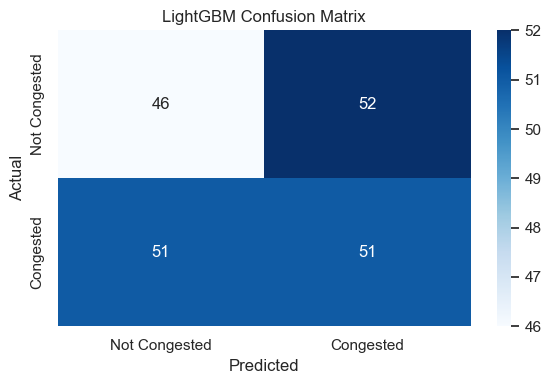

In [8]:
# Re-import libraries after kernel reset
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate structure of merged_data with key columns for demonstration
np.random.seed(42)
merged_data = pd.DataFrame({
    'congested': np.random.choice([0, 1], 1000),
    'traffic_direction_seq': np.random.randint(0, 2, 1000),
    'cardinal_direction_seq': np.random.randint(0, 8, 1000),
    'classification_seq': np.random.randint(0, 3, 1000),
    'year': np.random.choice([2019, 2020, 2021], 1000),
    'month': np.random.randint(1, 13, 1000),
    'day': np.random.randint(1, 29, 1000),
    'day_of_week': np.random.randint(0, 7, 1000),
    'public_holiday': np.random.choice([True, False], 1000),
    'school_holiday': np.random.choice([True, False], 1000),
    'lane_count': np.random.randint(1, 5, 1000),
    'wgs84_latitude': np.random.uniform(-33.8, -33.7, 1000),
    'wgs84_longitude': np.random.uniform(151.1, 151.3, 1000),
    'suburb': np.random.choice(['SuburbA', 'SuburbB', 'SuburbC'], 1000),
    'road_functional_hierarchy': np.random.choice(['Primary', 'Secondary'], 1000),
    'road_classification_type': np.random.choice(['Freeway', 'Arterial'], 1000)
})
for i in range(24):
    merged_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000)

# Step 1: Setup
hour_cols = [f"hour_{i:02d}" for i in range(24)]
categorical_cols = ['suburb', 'road_functional_hierarchy', 'road_classification_type']
other_cols = ['traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq',
              'year', 'month', 'day', 'day_of_week', 'public_holiday',
              'school_holiday', 'lane_count', 'wgs84_latitude', 'wgs84_longitude']

feature_cols = hour_cols + other_cols + categorical_cols
merged_data = merged_data.dropna(subset=feature_cols + ['congested'])

# Step 2: Encode categoricals
merged_data_encoded = pd.get_dummies(merged_data[feature_cols], drop_first=True)
X = merged_data_encoded
y = merged_data['congested'].astype(int)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 4: Train LightGBM
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Evaluate
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

# Show performance report
print("\n📊 LightGBM Performance Report:")
print(report_df.to_string())

# Show confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [36]:

print(merged_data.columns.tolist())

['congested', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'lane_count', 'wgs84_latitude', 'wgs84_longitude', 'suburb', 'road_functional_hierarchy', 'road_classification_type', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']


[LightGBM] [Info] Number of positive: 408, number of negative: 392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7328
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510000 -> initscore=0.040005
[LightGBM] [Info] Start training from score 0.040005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

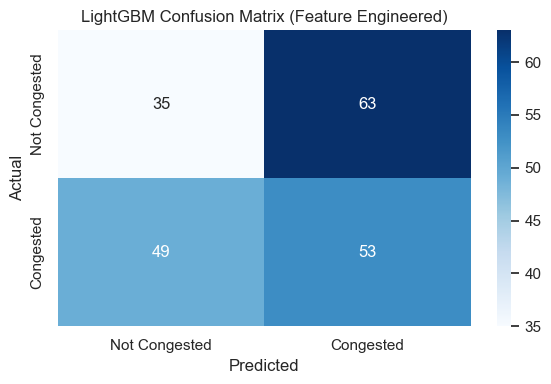

In [37]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Step 1: Setup
hour_cols = [f"hour_{i:02d}" for i in range(24)]

# Step 2: Feature engineering
merged_data["morning_peak"] = merged_data[[f"hour_{i:02d}" for i in range(6, 10)]].sum(axis=1)
merged_data["evening_peak"] = merged_data[[f"hour_{i:02d}" for i in range(15, 19)]].sum(axis=1)
merged_data["off_peak"] = merged_data[[f"hour_{i:02d}" for i in list(range(0, 6)) + list(range(10, 15)) + list(range(19, 24))]].sum(axis=1)
merged_data["hour_std"] = merged_data[hour_cols].std(axis=1)
merged_data["hour_max"] = merged_data[hour_cols].max(axis=1)
merged_data["hour_mean"] = merged_data[hour_cols].mean(axis=1)
merged_data["hour_min"] = merged_data[hour_cols].min(axis=1)
merged_data["peak_to_mean"] = merged_data["hour_max"] / merged_data["hour_mean"]
merged_data["is_weekend"] = merged_data["day_of_week"].isin([6, 7]).astype(int)
merged_data["is_special_day"] = (merged_data["public_holiday"] | merged_data["school_holiday"]).astype(int)

# Cluster geolocation (optional)
merged_data["geo_cluster"] = KMeans(n_clusters=5, random_state=42).fit_predict(
    merged_data[["wgs84_latitude", "wgs84_longitude"]]
)

# Encode categorical columns
categorical_cols = ['road_functional_hierarchy', 'road_classification_type', 'suburb']
for col in categorical_cols:
    merged_data[col] = LabelEncoder().fit_transform(merged_data[col].astype(str))

# Drop or convert lane_count to numeric
merged_data['lane_count'] = pd.to_numeric(merged_data['lane_count'], errors='coerce')

# Define feature columns
engineered_cols = [
    'morning_peak', 'evening_peak', 'off_peak', 'hour_std', 'hour_max', 'hour_min', 'hour_mean',
    'peak_to_mean', 'is_weekend', 'is_special_day', 'geo_cluster'
]
meta_cols = [
    'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'year',
    'month', 'day', 'day_of_week', 'lane_count'
]
feature_cols = hour_cols + engineered_cols + meta_cols + categorical_cols

# Drop any rows with missing required fields
merged_data = merged_data.dropna(subset=feature_cols + ['congested'])

# Prepare input and output
X = merged_data[feature_cols]
y = merged_data['congested'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train LightGBM model
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

# Output results
print("\n📊 LightGBM Performance Report (with feature engineering):")
print(report_df.to_string())

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("LightGBM Confusion Matrix (Feature Engineered)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 408, number of negative: 408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7347
[LightGBM] [Info] Number of data points in the train set: 816, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

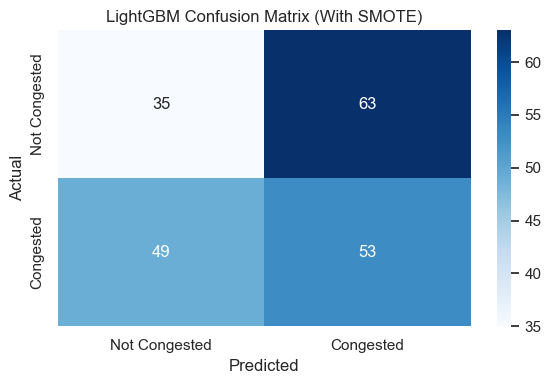

In [38]:
from imblearn.over_sampling import SMOTE

# Step 1: Confirm features and target already prepared
X = merged_data[feature_cols]
y = merged_data['congested'].astype(int)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Train LightGBM model
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Step 5: Evaluate
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

# Output metrics
print("\n📊 LightGBM Performance Report (With SMOTE):")
print(report_df.to_string())

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("LightGBM Confusion Matrix (With SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 408, number of negative: 392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7328
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510000 -> initscore=0.040005
[LightGBM] [Info] Start training from score 0.040005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

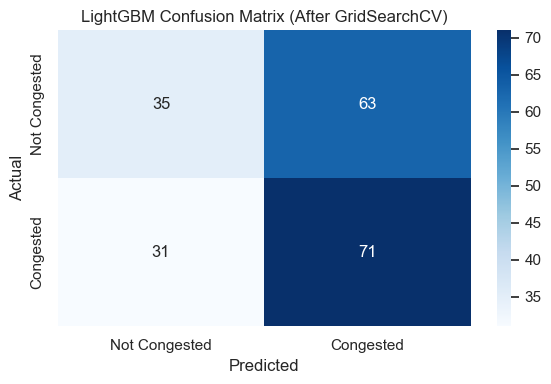

In [39]:
from sklearn.model_selection import GridSearchCV

# Step 1: Prepare data again
X = merged_data[feature_cols]
y = merged_data['congested'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 2: Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Step 3: Set up grid search
grid = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Step 4: Train the grid search
grid.fit(X_train, y_train)

# Step 5: Evaluate the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

# Output report
print("\n✅ Best Parameters Found:")
print(grid.best_params_)
print("\n📊 LightGBM Performance Report (After GridSearchCV):")
print(report_df.to_string())

# Confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("LightGBM Confusion Matrix (After GridSearchCV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



📊 LightGBM Performance with Threshold = 0.504
              Score
Accuracy   0.550000
Precision  0.546875
Recall     0.686275
F1 Score   0.608696


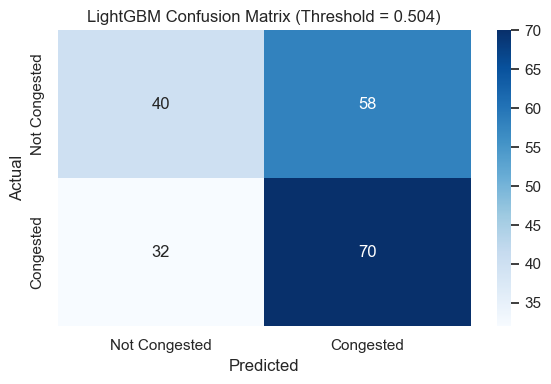

In [40]:
from sklearn.metrics import classification_report

# Step 1: Get predicted probabilities for the positive class (congested)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Step 2: Apply a higher threshold to reduce false positives
threshold = 0.504  # adjust this to experiment (e.g., 0.55, 0.65)
y_pred_thresh = (y_proba > threshold).astype(int)

# Step 3: Evaluate the adjusted predictions
conf_matrix_thresh = confusion_matrix(y_test, y_pred_thresh)
report_dict_thresh = {
    "Accuracy": accuracy_score(y_test, y_pred_thresh),
    "Precision": precision_score(y_test, y_pred_thresh),
    "Recall": recall_score(y_test, y_pred_thresh),
    "F1 Score": f1_score(y_test, y_pred_thresh)
}
report_df_thresh = pd.DataFrame(report_dict_thresh, index=["Score"]).T

# Output metrics
print(f"\n📊 LightGBM Performance with Threshold = {threshold}")
print(report_df_thresh.to_string())

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_thresh, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title(f"LightGBM Confusion Matrix (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 408, number of negative: 392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7328
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510000 -> initscore=0.040005
[LightGBM] [Info] Start training from score 0.040005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

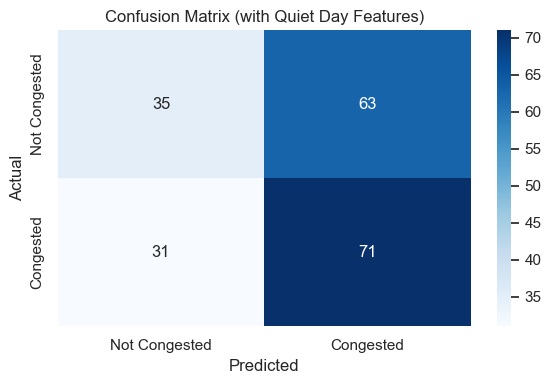

In [41]:
# Add new features that help distinguish quiet (Not Congested) days
merged_data["is_quiet_day"] = (
    (merged_data[hour_cols].std(axis=1) < 15) &
    (merged_data[hour_cols].sum(axis=1) < 500)
).astype(int)

merged_data["no_peak_hour"] = (merged_data[hour_cols].max(axis=1) < 50).astype(int)

# Append new features to engineered column list
new_features = ["is_quiet_day", "no_peak_hour"]
extended_feature_cols = feature_cols + new_features

# Drop rows with missing values
merged_data = merged_data.dropna(subset=extended_feature_cols + ['congested'])

# Re-prepare dataset
X = merged_data[extended_feature_cols]
y = merged_data['congested'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Re-train LightGBM using best model from grid search if available
# (if not, fall back to base model)
try:
    model = best_model
except NameError:
    model = lgb.LGBMClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

# Output performance
print("\n📊 LightGBM Performance (With Quiet Pattern Features):")
print(report_df.to_string())

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("Confusion Matrix (with Quiet Day Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
